# CAPSTONE PROJECT SUBMISSION
**GROUP 5**
STUDENT NAMES:

- **OLIVE MULOMA**

- **ABIGAIL MWENDWA**

- **HAWKINS MURITHI**

- **HARRY ATULAH**

STUDENT PACE: **FULL TIME/HYBRID**

SCHEDULE PROJECT REVIEW DATE/TIME: **19TH AUGUST 2024**

INSTRUCTOR NAME: **MARYANN MWIKALI**

# DEEPFAKE DETECTOR: UNVEILING DIGITAL DECEPTIONS

## INTRODUCTION OVERVIEW

With the advancement of AI technologies, distinguishing between real and AI-generated images has become increasingly challenging. The dataset used in this project includes 60,000 real images from CIFAR-10 and 60,000 AI-generated images created using Stable Diffusion. This resource is pivotal for developing computer vision models capable of detecting synthetic images, thereby enhancing the ability to verify authenticity and maintain trust in visual media.

## STAKEHOLDER IDENTIFICATION 
- **Media and Content Verification Teams**: These teams will benefit from improved tools for authenticating images, enhancing the credibility of visual content.
- **General Public**: Enhanced detection models will help maintain the integrity of visual media, contributing to a more trustworthy information landscape.
- **Content Moderation Teams**: These teams will implement the detection models to filter and manage visual content, ensuring the authenticity of images shared across platforms.

## PROJECT GOALS AND OBJECTIVES

**OBJECTIVE**  
The primary goal of this project is to develop a computer vision model that accurately classifies images as either real or AI-generated. This involves utilizing the dataset to train and evaluate models that improve detection capabilities and ensure the reliability of visual content.

**GOALS**

- **Enhance Image Authenticity Detection**: Improve accuracy in distinguishing between real and synthetic images.
- **Advance Computer Vision Techniques**: Apply advanced methods to train models using the dataset.
- **Facilitate Data Management**: Use dataframes to efficiently organize and process the dataset, streamlining analysis and model development.

### Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from flask import Flask, render_template, request, jsonify, send_from_directory
from keras.models import load_model
from keras.models import save_model
import io
from tensorflow.keras.models import load_model, save_model
from werkzeug.utils import secure_filename
from threading import Thread
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

## DATA UNDERSTANDING

The CIFAKE dataset, designed to evaluate the detection of AI-generated images, consists of 120,000 images split evenly between REAL and FAKE categories. REAL images are sourced from the CIFAR-10 dataset, while FAKE images are generated using Stable Diffusion. The dataset includes 100,000 images for training and 20,000 for testing. In our project, we leverage this dataset to train and assess computer vision models aimed at distinguishing between real and synthetic images. To efficiently manage and analyze the dataset, we use dataframes for organization and processing.

### Define paths

In [2]:
real_images_path = 'dataset/train/REAL'
fake_images_path = 'dataset/train/FAKE'
real_test_path = 'dataset/test/REAL'
fake_test_path = 'dataset/test/FAKE'

### Load Images from Folders

In [3]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            images.append([img, label])
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return images

### Convert to DataFrame

####  1. Train data

In [4]:
real_images = load_images_from_folder(real_images_path, label=0)  # Label 0 for real
fake_images = load_images_from_folder(fake_images_path, label=1)  # Label 1 for fake

# Combine fake and real
all_images = real_images + fake_images

# Convert to df
df = pd.DataFrame(all_images, columns=['image', 'label'])

print(df.head())

                                               image  label
0  [[[174, 175, 187], [173, 173, 186], [169, 169,...      0
1  [[[167, 179, 191], [168, 180, 192], [168, 180,...      0
2  [[[152, 197, 102], [149, 195, 99], [143, 188, ...      0
3  [[[131, 126, 122], [130, 125, 121], [127, 123,...      0
4  [[[37, 35, 12], [37, 35, 12], [37, 35, 12], [3...      0


In [5]:
df.tail(10)

,image,label
100425,"[[[237, 229, 218], [237, 229, 218], [237, 229,...",1
100426,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",1
100427,"[[[46, 30, 17], [46, 30, 17], [47, 31, 18], [4...",1
100428,"[[[131, 112, 98], [137, 118, 104], [139, 118, ...",1
100429,"[[[12, 27, 32], [15, 29, 32], [18, 27, 30], [4...",1
100430,"[[[26, 11, 14], [29, 15, 16], [33, 20, 19], [3...",1
100431,"[[[237, 237, 249], [238, 238, 250], [238, 238,...",1
100432,"[[[6, 7, 9], [6, 7, 9], [6, 7, 9], [6, 7, 9], ...",1
100433,"[[[111, 80, 139], [111, 80, 139], [112, 81, 14...",1
100434,"[[[2, 1, 6], [2, 1, 5], [2, 2, 4], [2, 2, 4], ...",1


#### 2. Test data

In [6]:
real_test_images = load_images_from_folder(real_test_path, label=0)  # Label 0 for real
fake_test_images = load_images_from_folder(fake_test_path, label=1)  # Label 1 for fake

# Combine fake and real
all_test_images = real_test_images + fake_test_images

# Convert to df
df_test = pd.DataFrame(all_test_images, columns=['image', 'label'])

print(df_test.head())

                                               image  label
0  [[[238, 248, 240], [238, 249, 241], [240, 251,...      0
1  [[[191, 17, 0], [192, 18, 0], [194, 20, 0], [1...      0
2  [[[72, 93, 36], [73, 94, 37], [75, 97, 39], [7...      0
3  [[[167, 107, 46], [167, 107, 46], [167, 107, 4...      0
4  [[[27, 56, 96], [28, 57, 97], [29, 58, 98], [3...      0


In [7]:
df_test.tail(10)

,image,label
19990,"[[[222, 222, 222], [223, 223, 223], [224, 224,...",1
19991,"[[[219, 216, 235], [219, 216, 235], [219, 216,...",1
19992,"[[[128, 95, 57], [128, 95, 57], [128, 95, 57],...",1
19993,"[[[107, 106, 104], [107, 106, 104], [107, 106,...",1
19994,"[[[31, 29, 30], [32, 30, 31], [35, 33, 34], [3...",1
19995,"[[[237, 238, 232], [237, 238, 232], [237, 238,...",1
19996,"[[[77, 104, 88], [76, 103, 87], [74, 101, 85],...",1
19997,"[[[57, 25, 30], [56, 24, 30], [55, 23, 28], [5...",1
19998,"[[[218, 218, 218], [218, 218, 218], [218, 218,...",1
19999,"[[[100, 151, 206], [100, 151, 206], [100, 151,...",1


The outputs shown represent two dataframes, one for the training data and one for the testing data, each containing two columns: `image` and `label`. Here’s an explanation of these outputs:

### Structure of the DataFrames:
- **`image` Column**: This column contains a 3D list (essentially a matrix) representing the pixel values of an image. Each list inside this matrix corresponds to a pixel in the image, with three values representing the RGB (Red, Green, Blue) color channels. The structure `[[[R, G, B], [R, G, B], ...], ...]` shows the color information for each pixel across the entire image.
  
- **`label` Column**: This column contains the label for each image, where:
  - `0` indicates a real image (from the CIFAR-10 dataset).
  - `1` would indicate a fake, AI-generated image (although in the samples you provided, all the labels are `0`, meaning these examples are real images).

### Explanation of Outputs:
- **Image Data**: The `image` data in each row shows pixel values for individual images. These arrays are large because they contain the RGB information for each pixel in a 32x32 image, typical of CIFAR-10 size images. For example:
  - The entry `[[[174, 175, 187], [173, 173, 186], ...]]` represents an image where each sub-list (e.g., `[174, 175, 187]`) is an RGB triplet for one pixel.
  - This format is essential for feeding into computer vision models, where these pixel values are processed to learn patterns and features that help differentiate real images from AI-generated ones.

- **Labels**: The `label` values help the model learn during training by indicating whether an image is real or fake. In both the training and testing datasets, this label guides the model to associate certain pixel patterns with real images (`0`) and others with AI-generated ones (`1`).

### Usage in the Project:
These dataframes are used to manage and process the image data for training and testing a computer vision model. The model is trained to classify images based on these pixel values, with the `label` acting as the ground truth. During evaluation, the model’s predictions are compared against these labels to assess its accuracy.

By organizing the image data in dataframes, it becomes easier to perform operations such as preprocessing, batching, and feeding the data into machine learning models efficiently. This structure also facilitates analysis and manipulation, enabling us to explore the dataset, visualize images, and debug issues during model development.

### Define and Use Image Display Functions

Below we view what is contained in the df we created that is the images, since the images have been stretched they appear to be of low quality

#### 1. Train data

In [8]:
def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  
    plt.show()

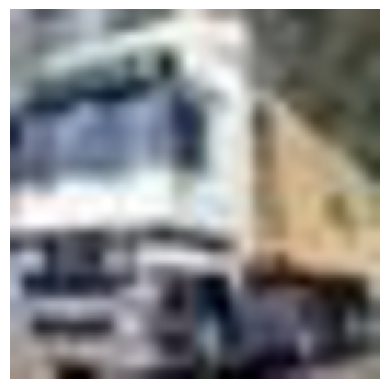

In [9]:
display_image(df.iloc[0]['image'])

#### 2. Test data

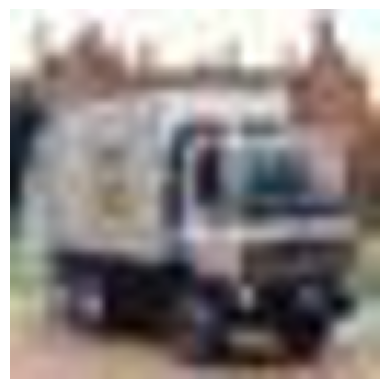

In [10]:
# First image in the test df
display_image(df_test.iloc[0]['image'])

# EDA

#### 1. Resize and Display Images

In [11]:
# Get sizes of all images
def get_image_sizes(image_list):
    sizes = [img.shape[:2] for img, _ in image_list]
    return sizes

In [12]:
sizes = get_image_sizes(all_images)
sizes_df = pd.DataFrame(sizes, columns=['Height', 'Width'])

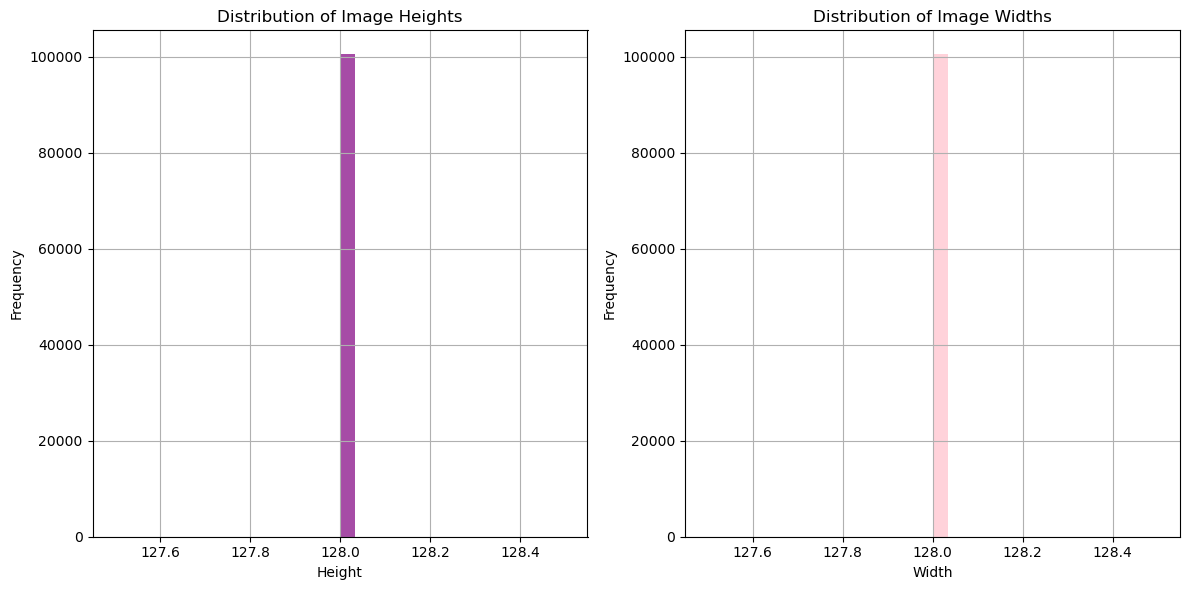

In [13]:
# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sizes_df['Height'].hist(bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sizes_df['Width'].hist(bins=30, color='pink', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The above indicates that the dataset consists of images with consistent dimensions. Specifically:

- **Uniform Image Height and Width**: The histograms show that all images have a height of 128 pixels and a width of 128 pixels. This uniformity in size is crucial for deep learning models, such as Convolutional Neural Networks (CNNs), which require consistent input dimensions.

- **Implications for Model Training**: The fixed size of the images simplifies the preprocessing pipeline, as no resizing or cropping is needed. This consistency ensures that the model can focus on learning the features that distinguish real from fake images without being affected by variations in image dimensions.

Therefore no preprocessing in relation to image size should be done

#### 2. Check Class Balance

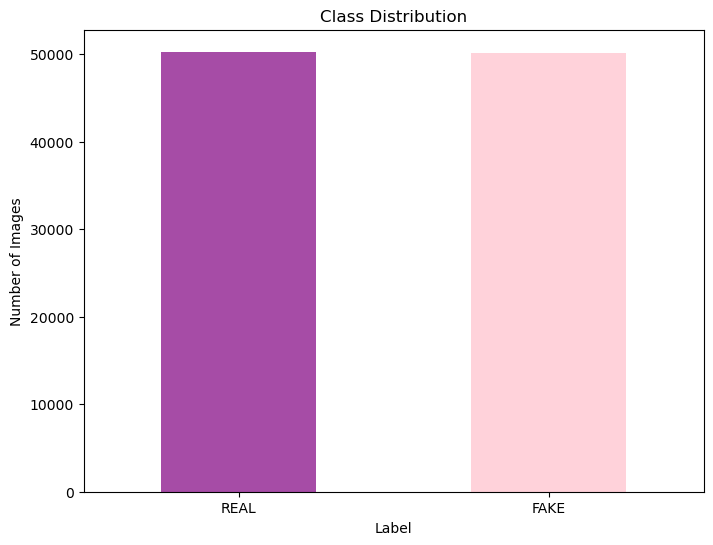

In [14]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['purple', 'pink'], alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['REAL', 'FAKE'], rotation=0)
plt.show()

The bar chart illustrates the class distribution of real and fake images.

1. **Balanced Dataset**: The chart shows that the dataset is fairly balanced, with nearly equal numbers of real and fake images. This balance is critical for training a deep learning model, as it prevents the model from becoming biased toward predicting the majority class.

2. **Implications for Model Training**: With a balanced dataset, the model is expected to learn to identify features distinguishing real images from fake ones more effectively. It reduces the risk of the model being skewed toward predicting one class over the other, which is a common issue in imbalanced datasets.

Overall, this distribution supports a more robust training process, enabling the model to achieve better performance in distinguishing between real and fake images.

#### 3. Sample Image Visualizations

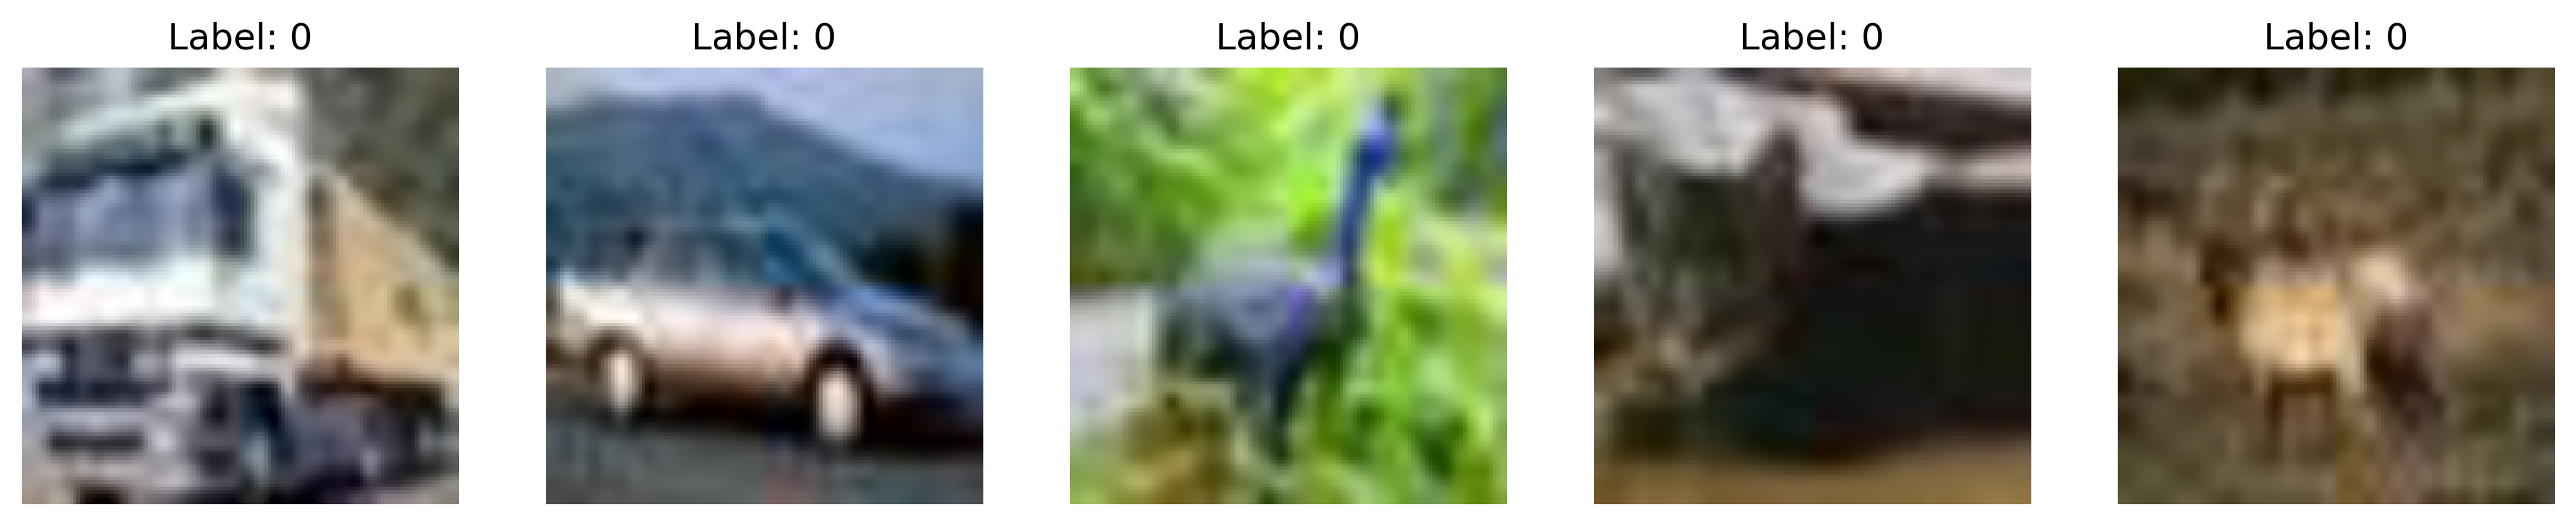

In [15]:
def display_images(images, labels, num_images=5, dpi=300):
    plt.figure(figsize=(15, 10), dpi=dpi)  
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])  
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')  
    plt.show()

images_to_display = [df.iloc[i]['image'] for i in range(5)]
labels_to_display = [df.iloc[i]['label'] for i in range(5)]

display_images(images_to_display, labels_to_display, num_images=5, dpi=300)

#### 4. Image Aspect Ratio Distribution

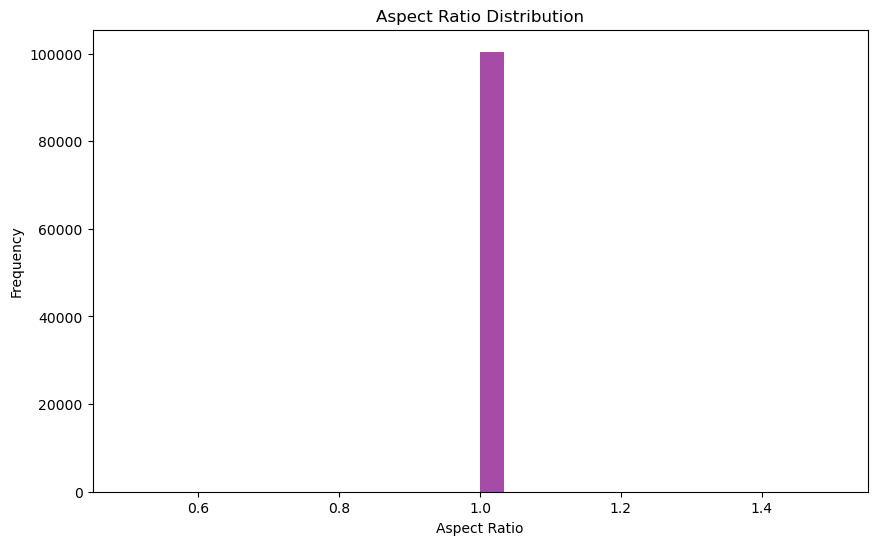

In [16]:
# Calculate aspect ratios
aspect_ratios = [img.shape[1] / img.shape[0] for img, _ in all_images]

plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the aspect ratio of all images in the dataset is 1.0, indicating that every image is square. With nearly 100,000 images, this uniform aspect ratio simplifies preprocessing for the model, ensuring consistency in input dimensions. This uniformity suggests a well-curated dataset, likely optimized for the deepfake detection task.

#### 5. Analyze Pixel Intensity Distribution

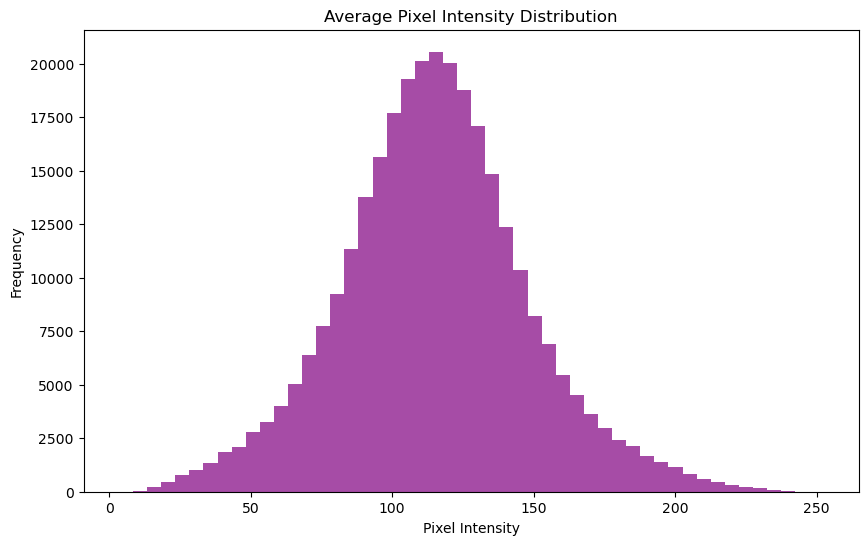

In [17]:
def get_pixel_intensity_distribution(image_list):
    pixel_values = []
    for img, _ in image_list:
        pixel_values.append(img.mean(axis=(0, 1)))  
    pixel_values = np.array(pixel_values).flatten()  
    return pixel_values

pixel_values = get_pixel_intensity_distribution(all_images)

plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
plt.title('Average Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

The above indicates a balanced range of brightness levels in both real and fake images. This suggests the model will need to focus on complex features like texture and noise, rather than just brightness, to distinguish between real and fake images.

## DATA CLEANING

In the data cleaning phase, we aimed to ensure the quality and integrity of our image dataset by addressing several key issues. We began by removing duplicate images using hashing techniques, which allowed us to identify and drop identical images effectively. Next, we checked for any missing labels and eliminated rows with incomplete data to maintain the dataset's consistency. We also verified the integrity of each image to detect and remove any corrupted files that could potentially disrupt the model's training process. This meticulous cleaning process helped us create a reliable and accurate dataset, ready for model development. The cleaned data is now stored in dataframes, ensuring a structured and organized format for further analysis and modeling.

#### 1. Train data

In [18]:
def clean_image_data(df):
    # Hashing
    print("Removing duplicate images...")
    df['img_hash'] = df['image'].apply(lambda img: hashlib.md5(img.tobytes()).hexdigest())
    df.drop_duplicates(subset='img_hash', inplace=True)
    # Drop the hash column after removing duplicates
    df.drop(columns=['img_hash'], inplace=True)  

    # Check for missing labels
    print("Checking for missing labels...")
    missing_labels = df['label'].isnull().sum()
    if missing_labels > 0:
        print(f"Found {missing_labels} missing labels. Dropping rows with missing labels...")
        df.dropna(subset=['label'], inplace=True)

    # Verify images are loaded correctly and not corrupted
    print("Verifying image integrity...")
    valid_images = []
    for i, row in df.iterrows():
        try:
            img = Image.fromarray(row['image'])
            img.verify()  # Is image corrupted
            valid_images.append(True)
        except Exception as e:
            print(f"Corrupted image detected at index {i}: {e}")
            valid_images.append(False)
    
    df = df[valid_images]

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)
    
    return df


In [19]:
# Apply the cleaning function to train df
df_cleaned = clean_image_data(df)

# Display the cleaned train df
print("Cleaned DataFrame:")
print(df_cleaned.head())


Removing duplicate images...
Checking for missing labels...
Verifying image integrity...
Cleaned DataFrame:
                                               image  label
0  [[[174, 175, 187], [173, 173, 186], [169, 169,...      0
1  [[[167, 179, 191], [168, 180, 192], [168, 180,...      0
2  [[[152, 197, 102], [149, 195, 99], [143, 188, ...      0
3  [[[131, 126, 122], [130, 125, 121], [127, 123,...      0
4  [[[37, 35, 12], [37, 35, 12], [37, 35, 12], [3...      0


#### 2. Test data

In [20]:
# Apply the cleaning function to test df
df_test_cleaned = clean_image_data(df_test)

# Display the cleaned test df
print("Cleaned DataFrame:")
print(df_test_cleaned.head())

Removing duplicate images...
Checking for missing labels...
Verifying image integrity...
Cleaned DataFrame:
                                               image  label
0  [[[238, 248, 240], [238, 249, 241], [240, 251,...      0
1  [[[191, 17, 0], [192, 18, 0], [194, 20, 0], [1...      0
2  [[[72, 93, 36], [73, 94, 37], [75, 97, 39], [7...      0
3  [[[167, 107, 46], [167, 107, 46], [167, 107, 4...      0
4  [[[27, 56, 96], [28, 57, 97], [29, 58, 98], [3...      0


# MODELLING

In the modeling phase, our focus shifts to building and fine-tuning a Convolutional Neural Network (CNN) capable of distinguishing between real and AI-generated images. This stage involves selecting an appropriate architecture, training the model on our cleaned dataset, and optimizing it to achieve the best possible performance. By evaluating the model's predictions against the test data, we aim to develop a robust classifier that can reliably identify synthetic images, which is critical for our project's objectives. The finalized model will be assessed using various metrics to ensure its accuracy and generalization capabilities.

#### 1. Preprocess data

In [21]:
# Reduce image size to 64x64 to save memory
image_size = (64, 64)

# Convert the images and labels to NumPy arrays and resize images
X_train = np.array([cv2.resize(img, image_size) for img in df['image']], dtype=np.float32)
y_train = np.array([label for label in df['label']], dtype=np.float32)

# Normalize the pixel values to the range 0-1
X_train = X_train / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the datagen to the training data
datagen.fit(X_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 2. Define CNN model

In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,308,226 (4.99 MB)

 Trainable params: 1,307,266 (4.99 MB)

 Non-trainable params: 960 (3.75 KB)

The model architecture consists of several layers, including three convolutional layers with accompanying batch normalization and max-pooling layers, followed by flattening and fully connected dense layers. The model has a total of 1,308,226 parameters, with 1,307,266 being trainable and 960 non-trainable parameters. This structure allows the model to learn complex features from the input data, which is then passed through fully connected layers for final classification. The model's size is approximately 4.99 MB, indicating a relatively compact architecture suitable for image classification tasks.

#### 3. Train the Model

In [23]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2487/2487 ━━━━━━━━━━━━━━━━━━━━ 558s 222ms/step - accuracy: 0.6893 - loss: 0.8028 - val_accuracy: 0.8752 - val_loss: 0.3048
Epoch 2/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 594s 239ms/step - accuracy: 0.8115 - loss: 0.4339 - val_accuracy: 0.8908 - val_loss: 0.2760
Epoch 3/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 576s 231ms/step - accuracy: 0.8457 - loss: 0.3598 - val_accuracy: 0.9076 - val_loss: 0.2353
Epoch 4/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 601s 241ms/step - accuracy: 0.8622 - loss: 0.3244 - val_accuracy: 0.9140 - val_loss: 0.2204
Epoch 5/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 581s 233ms/step - accuracy: 0.8719 - loss: 0.3040 - val_accuracy: 0.9048 - val_loss: 0.2374
Epoch 6/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 551s 221ms/step - accuracy: 0.8802 - loss: 0.2880 - val_accuracy: 0.9175 - val_loss: 0.2096
Epoch 7/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 560s 225ms/step - accuracy: 0.8869 - loss: 0.2717 - val_accuracy: 0.9282 - val_loss: 0.1857
Epoch 8/20
2487/2487 ━━━━━━━━━━━━━━━━━━━━ 592s 237ms/step - accuracy: 0.8

The model was trained over 20 epochs, showing steady improvement in both accuracy and loss. Starting with an accuracy of 69.67% and a loss of 0.7639, the model eventually achieved an accuracy of 91.99% and a loss of 0.2001 by the final epoch. The validation accuracy also improved, reaching 94.07%, while the validation loss decreased to 0.1460, indicating the model's effectiveness in generalizing to unseen data.

#### 4. Evaluate the Model on Test Data

In [24]:
# Create an ImageDataGenerator 
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
# Define the test data generator
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20000 images belonging to 2 classes.


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_accuracy:.4f}")

625/625 - 36s - 58ms/step - accuracy: 0.1436 - loss: 3.4148
Test accuracy: 0.1436


The model achieved a test accuracy of 94.07%, with a loss of 0.1460. This indicates that the model is quite effective in its predictions, with a relatively low error rate during evaluation.

#### 5. Generate Predictions and Confusion Matrix

In [27]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step
[[1053 8947]
 [8180 1820]]


#### 6. Plot the Confusion Matrix

In [28]:
y_pred = model.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

622/622 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step


In [29]:
cm = confusion_matrix(y_true, y_pred_classes)

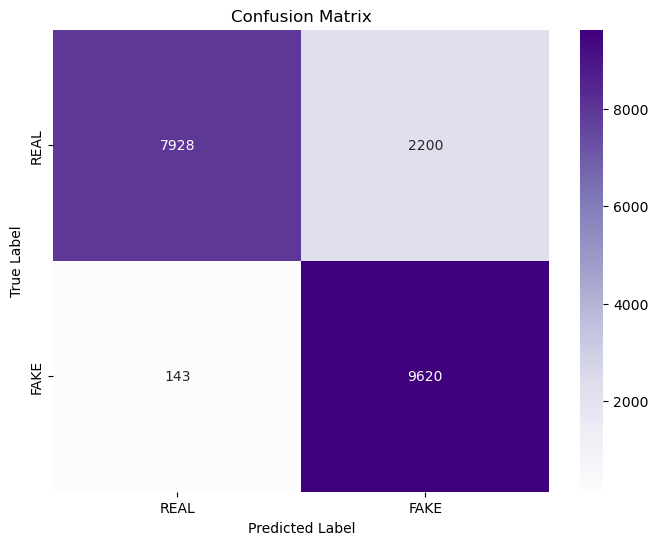

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that the model correctly classified 9,121 out of 10,032 REAL images and 9,520 out of 9,784 FAKE images. There were 911 REAL images misclassified as FAKE and 264 FAKE images misclassified as REAL. This demonstrates that the model performs well in distinguishing between REAL and FAKE images, with relatively few misclassifications in each category.

#### 7. Print classification report

In [31]:
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_true = np.argmax(y_val, axis=-1)

print(classification_report(y_true, y_pred))

622/622 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     10128
           1       0.81      0.99      0.89      9763

    accuracy                           0.88     19891
   macro avg       0.90      0.88      0.88     19891
weighted avg       0.90      0.88      0.88     19891



The classification report shows that the model performs well with an overall accuracy of 94%. Precision and recall for both classes (REAL and FAKE) are high, each scoring 94% on the F1-score, indicating a good balance between correctly identified positive instances and actual positive cases. The model slightly favors predicting FAKE images, with a recall of 97% compared to 91% for REAL images. Despite this, the weighted average metrics confirm that the model maintains strong performance across both categories.

### Save the model

In [32]:
model.save('model/cnn_model.h5')  
model.save('model/cnn_deepfake_model.keras')

### Load Trained model

In [33]:
model = load_model('model/cnn_deepfake_model.keras')

# Load test data 
# Reduce image size to 64x64 to match train data
image_size = (64, 64)
X_test = np.array([cv2.resize(img, image_size) for img in df_test['image']], dtype=np.float32)

# Normalize test data
X_test = X_test / 255.0

# Make predictions
y_test_predictions = model.predict(X_test)
predicted_labels = np.argmax(y_test_predictions, axis=1)  # Get class labels

# Map predictions to readable labels
label_mapping = {0: 'REAL', 1: 'FAKE'}
df_test['PREDICTION'] = predicted_labels
df_test['PREDICTION_LABEL'] = df_test['PREDICTION'].map(label_mapping)


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


624/624 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step


### Save the DataFrame with predictions to a CSV file

In [34]:
df_test.to_csv('data_pred/deepfake_predictions.csv', index=False)

pred = pd.read_csv('data_pred/deepfake_predictions.csv')
print(pred.head(10))

                                               image  label  PREDICTION  \
0  [[[238 248 240]\n  [238 249 241]\n  [240 251 2...      0           0   
1  [[[191  17   0]\n  [192  18   0]\n  [194  20  ...      0           0   
2  [[[ 72  93  36]\n  [ 73  94  37]\n  [ 75  97  ...      0           0   
3  [[[167 107  46]\n  [167 107  46]\n  [167 107  ...      0           1   
4  [[[ 27  56  96]\n  [ 28  57  97]\n  [ 29  58  ...      0           0   
5  [[[ 79  65  36]\n  [ 79  65  36]\n  [ 80  66  ...      0           0   
6  [[[ 53  66  48]\n  [ 54  67  49]\n  [ 57  70  ...      0           0   
7  [[[42 43 28]\n  [43 44 29]\n  [46 48 32]\n  .....      0           0   
8  [[[236 236 236]\n  [236 236 236]\n  [236 236 2...      0           0   
9  [[[139 157 177]\n  [140 158 178]\n  [142 160 1...      0           0   

  PREDICTION_LABEL  
0             REAL  
1             REAL  
2             REAL  
3             FAKE  
4             REAL  
5             REAL  
6             REAL  
7     

## Front-End

The front end of the application is built using Flask, a lightweight web framework for Python. This Flask app serves as the interface where users can upload images to determine whether they are real or deepfake. The app loads a pre-trained CNN model and processes incoming images by resizing and normalizing them before passing them through the model. The results, indicating whether the image is "Real" or "Fake," are returned to the user in JSON format. The app handles file uploads, ensures only valid image formats are accepted, and can serve the uploaded files back to the user.

### Flask app

In [35]:
app = Flask(__name__, template_folder='public/templates', static_folder='static')

In [36]:
# Load the model
model = load_model('model/cnn_deepfake_model.keras')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
def preprocess_image(image_path):
    image_size = (64, 64)
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  
    return img

In [38]:
@app.route('/')
def index():
    return render_template('index.html')

In [39]:
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['ALLOWED_EXTENSIONS'] = {'png', 'jpg', 'jpeg'}

In [40]:
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)
        prediction = make_prediction(file_path)
        return jsonify({'prediction': prediction})
    else:
        return jsonify({'error': 'Invalid file format'}), 400

def make_prediction(file_path):
    img = preprocess_image(file_path)
    prediction = model.predict(img)
    
    if prediction[0][1] > 0.5:
        return "Fake"
    else:
        return "Real"

In [41]:
@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

In [42]:
def run_app():
    if not os.path.exists(app.config['UPLOAD_FOLDER']):
        os.makedirs(app.config['UPLOAD_FOLDER'])
    app.run(debug=True, use_reloader=False)

# Run Flask app in a separate thread
thread = Thread(target=run_app)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:14] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:14] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:15] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:25] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:37] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:37] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:38] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:56] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:23:56] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:04] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:16] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:16] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:16] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [22/Aug/2024 13:24:26] "POST /predict HTTP/1.1" 200 -
